### Imports

In [1]:
import pandas as pd
import numpy as np
import random
import math

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import seaborn as sns
sns.set_style("whitegrid", {"grid.linestyle": ":"})
# sns.set_style("darkgrid", {"grid.linestyle": ":"})
sns.set_context("paper", rc={"font.size":11.5,"axes.titlesize":13,"axes.labelsize":11.5})   

sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

import recmetrics

from sklearn.metrics import mean_absolute_error

from surprise import Dataset, get_dataset_dir, Reader, accuracy
from surprise import KNNWithZScore
from surprise.model_selection import train_test_split, GridSearchCV, cross_validate, KFold

import warnings
import itertools
from itertools import chain

np.random.seed(1) # control randomness

### Dataset (ml-100k)

In [2]:
reader = Reader(line_format="user item rating", sep="\t")
data = Dataset.load_from_file("ml-100k/u.data", reader=reader)

### Assessing Neighbourhood Size and Correlation

The previous MAE computation value when using a randomly generated dataset was quite high, most likely due to there being a low correlation/pattern between our artificial users and items (movies); so we use a dataset (ml-100k) that has been collected from an established organisation and mimics real world data.

We have so far only used Pearson's correlation coefficient with a default k = 40 to find the linear correlation between our users/items. The next section looks to investigate the impact these values have on the loss value from our chosen dataset and to validate the literature claims.

We opt to use only a single evaluation for each parameter combination as the choice of using a cross validation method significantly increases the cells computation time which is not necessary for our investigation. It also gives results that are disjointed and not as smooth in comparison to a single evaluation.

In [3]:
trainset, testset = train_test_split(data, test_size=0.25) # train test split

similarity = ['cosine', 'msd', 'pearson']
k_val = [1, 5, 10, 20, 30, 50, 70, 100, 150, 200]

results = []
temp = []

# calculate mean absolute error at varing similarity measures and k values
for i, j in itertools.product(similarity, k_val):
#     print(i,j)
    algo = KNNWithZScore(k=j, sim_options={"name": i, "user_based": True}, verbose=False)
    predictions = algo.fit(trainset).test(testset) # training & testing
    
    temp.append(accuracy.mae(predictions, verbose=False))
    if (j == k_val[-1]):
        results.append(temp)
        temp = []

df = pd.DataFrame(results).T.rename(columns={0:similarity[0], 1:similarity[1], 2:similarity[2]})
df.index = k_val

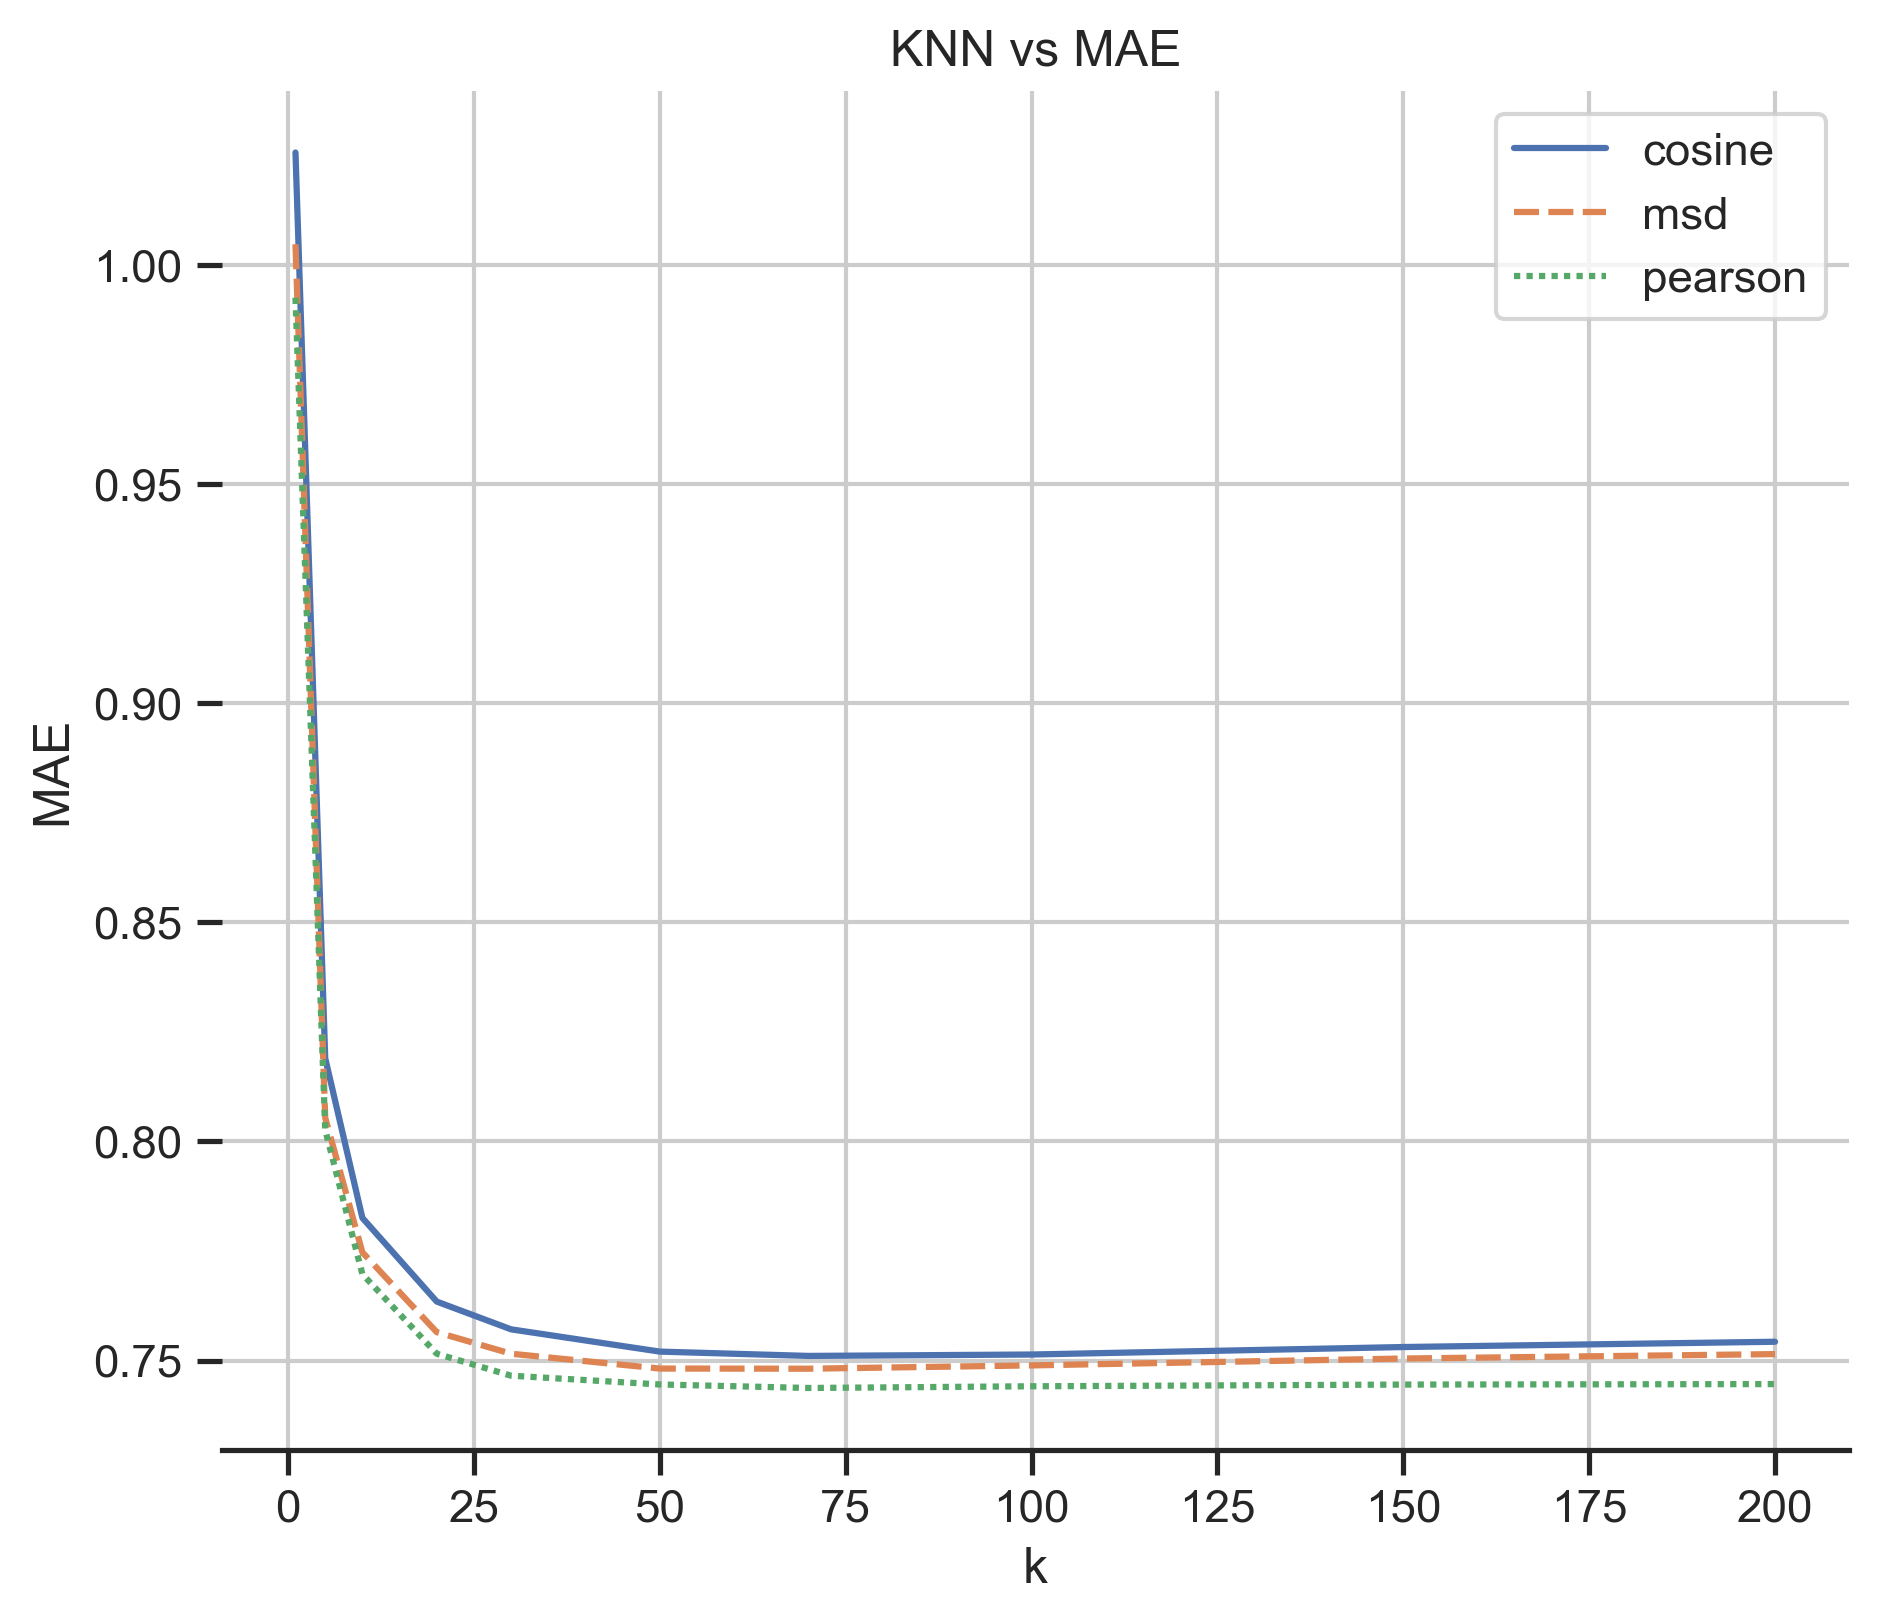

In [4]:
# plot Similarity Measure vs. K Nearest Neighbours
fig, ax = plt.subplots(figsize=(7,6))

sns.despine(left=True);
sns.lineplot(data=df)

plt.title('KNN vs MAE')
plt.xlabel('k')
plt.ylabel('MAE')
plt.grid()
plt.show()

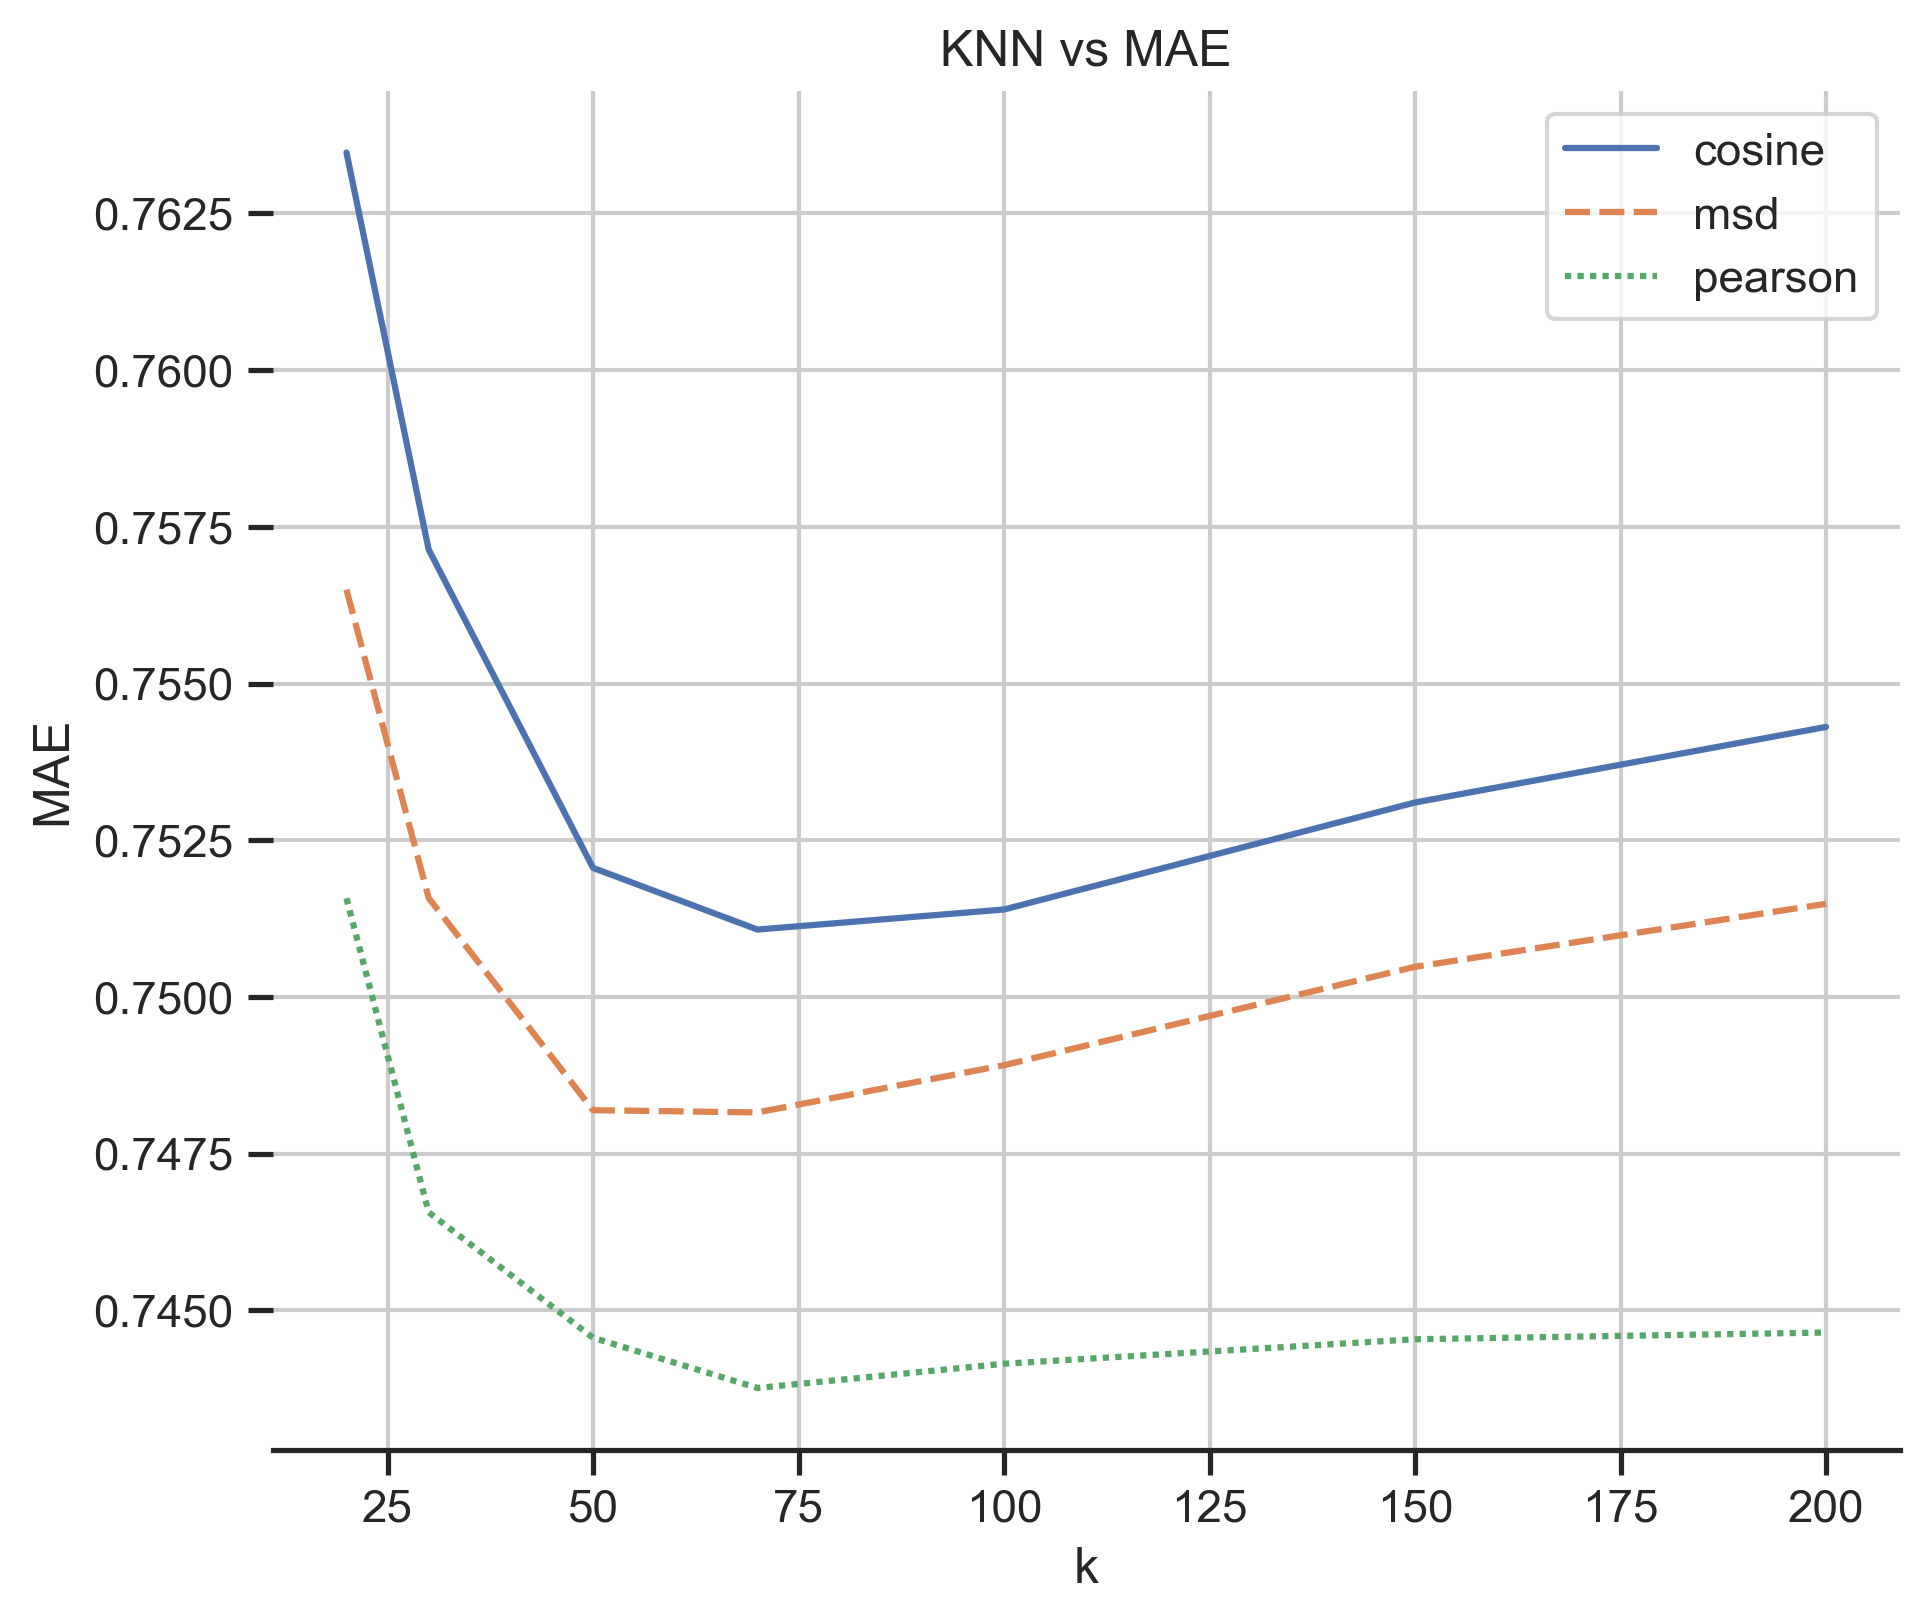

In [5]:
fig, ax = plt.subplots(figsize=(7,6))

sns.despine(left=True);
sns.lineplot(data=df[3:])

plt.title('KNN vs MAE')
plt.xlabel('k')
plt.ylabel('MAE')
plt.grid()
plt.show()

## Further Data Analysis

In [6]:
trainset = data.build_full_trainset() # fit to full dataset

sim_options = {
    "name": "pearson",
    "user_based": False
}

algo_item_based = KNNWithZScore(sim_options=sim_options)
algo_item_based.fit(trainset) # compute similarity matrix (training)

Computing the pearson similarity matrix...
Done computing similarity matrix.


Raw and inner id - https://surprise.readthedocs.io/en/stable/FAQ.html?highlight=raw#what-are-raw-and-inner-ids

In [7]:
"""
Read the u.item file from MovieLens 100-k dataset and return two mappings to convert raw ids into 
    movie names and movie names into raw ids.
"""
def read_item_names():
    file_name = get_dataset_dir() + "/ml-100k/ml-100k/u.item"

    rid_to_name = {}
    name_to_rid = {}
    with open(file_name, encoding="ISO-8859-1") as f:
        for line in f:
            line = line.split("|")
            rid_to_name[line[0]] = line[1]
            name_to_rid[line[1]] = line[0]

    return rid_to_name, name_to_rid

In [8]:
def get_movie_neighbours(movie_name, k, algo):
    """
    :type movie_name: str
    :type k: int
    :type algo: surprise.KNNWithZScore
    :rtype: List[str]
    """
    # Read the mappings raw id <-> movie name
    rid_to_name, name_to_rid = read_item_names() 

    # Retrieve inner id of the movie
    movie_raw_id = name_to_rid[movie_name]
    movie_inner_id = algo.trainset.to_inner_iid(movie_raw_id)

    # Retrieve inner ids of the nearest neighbors of Toy Story.
    neighbors = algo.get_neighbors(movie_inner_id, k=k-1)

    # Convert inner ids of the neighbors into names.
    neighbors = (
        algo.trainset.to_raw_iid(inner_id) for inner_id in neighbors
    )
    neighbors = (rid_to_name[rid] for rid in neighbors)

    k_neighbours = []
    for movie in neighbors:
        k_neighbours.append(movie)
    
    return k_neighbours

In [9]:
get_movie_neighbours('Toy Story (1995)', 10, algo_item_based)

['Line King: Al Hirschfeld, The (1996)',
 'Inkwell, The (1994)',
 'Stars Fell on Henrietta, The (1995)',
 'Critical Care (1997)',
 'Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)',
 'Jerky Boys, The (1994)',
 'Scarlet Letter, The (1995)',
 'Stranger, The (1994)',
 'Newton Boys, The (1998)']

### Multi-hot Encoding

In [10]:
# list of possible movie genres
genres = pd.read_csv('ml-100k/u.genre', sep='\t', header=None).apply(lambda row : row.values[0].split('|')[0], axis = 1)
genres

0         unknown
1          Action
2       Adventure
3       Animation
4      Children's
5          Comedy
6           Crime
7     Documentary
8           Drama
9         Fantasy
10      Film-Noir
11         Horror
12        Musical
13        Mystery
14        Romance
15         Sci-Fi
16       Thriller
17            War
18        Western
dtype: object

In [11]:
# read items file (movie properties)
movies = pd.read_csv('ml-100k/u.item', sep='|', encoding="ISO-8859-1", header=None)
movies.rename(columns={0:'movieId',1:'movie_name',2:'year',3:np.nan,4:'url'}, inplace=True)
movies.head()

,movieId,movie_name,year,NaN,url,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [12]:
# movies df with relevent genre column names 
columns = ['movieId', 'name', 'year', None, 'url']
columns.extend(genres.array)
movies = pd.read_csv('ml-100k/u.item', sep='|', names=columns, encoding="ISO-8859-1", header=None).set_index('movieId')

genres_df = movies.iloc[:,4:].replace(1, pd.Series(movies.columns, movies.columns)) # replace 1 with genre column name

genres_arr = []

# columns representing genres are then converted to a single string for each row representing their genres seperated by commas
for index, row in genres_df.iterrows():
    genres_arr.append(", ".join(list(filter(None, row.values))))

genres_df = movies.iloc[:,0:1] # movieId, name
genres_df['genres'] = genres_arr
genres_df

,name,genres
movieId,,
1,Toy Story (1995),"Animation, Children's, Comedy"
2,GoldenEye (1995),"Action, Adventure, Thriller"
3,Four Rooms (1995),Thriller
4,Get Shorty (1995),"Action, Comedy, Drama"
5,Copycat (1995),"Crime, Drama, Thriller"
...,...,...
1678,Mat' i syn (1997),Drama
1679,B. Monkey (1998),"Romance, Thriller"
1680,Sliding Doors (1998),"Drama, Romance"


### Investigate Genre Count

In [13]:
k_neighbours = get_movie_neighbours('Toy Story (1995)', 10, algo_item_based) # demo
k_neighbours

['Line King: Al Hirschfeld, The (1996)',
 'Inkwell, The (1994)',
 'Stars Fell on Henrietta, The (1995)',
 'Critical Care (1997)',
 'Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)',
 'Jerky Boys, The (1994)',
 'Scarlet Letter, The (1995)',
 'Stranger, The (1994)',
 'Newton Boys, The (1998)']

In [14]:
# view genre list for the movie 'Toy Story (1995)'
genres_df.loc[genres_df['name'] == 'Toy Story (1995)']['genres'][1]

"Animation, Children's, Comedy"

In [15]:
genres_df.loc[genres_df['name'].isin(k_neighbours)]

,name,genres
movieId,,
341,Critical Care (1997),Comedy
1106,"Newton Boys, The (1998)","Crime, Drama"
1186,"Inkwell, The (1994)","Comedy, Drama"
1242,"Old Lady Who Walked in the Sea, The (Vieille q...",Comedy
1372,"Stranger, The (1994)",Action
1442,"Scarlet Letter, The (1995)",Drama
1464,"Stars Fell on Henrietta, The (1995)",Drama
1484,"Jerky Boys, The (1994)","Action, Comedy"
1497,"Line King: Al Hirschfeld, The (1996)",Documentary


In [16]:
"""Count the number of unique genres from a list of movie titles"""

def genre_count(k_neighbours):
    """
    :type k_neighbours: List[str]
    :rtype: pd.Series
    """
    # select movies and their corresponding genres (converted to array)
    arr = genres_df.loc[genres_df['name'].isin(k_neighbours)]['genres'].values
    
    temp= []
    for i in range(len(arr)):
        temp.append(arr[i].split(", ")) # seperate strings consisting of multiple genres

    df = pd.DataFrame(list(chain.from_iterable(temp)), columns=['genres']) # dataframe with flattened 2D array
    return df.groupby('genres')['genres'].count().sort_values(axis=0, ascending=False) # count of each genre

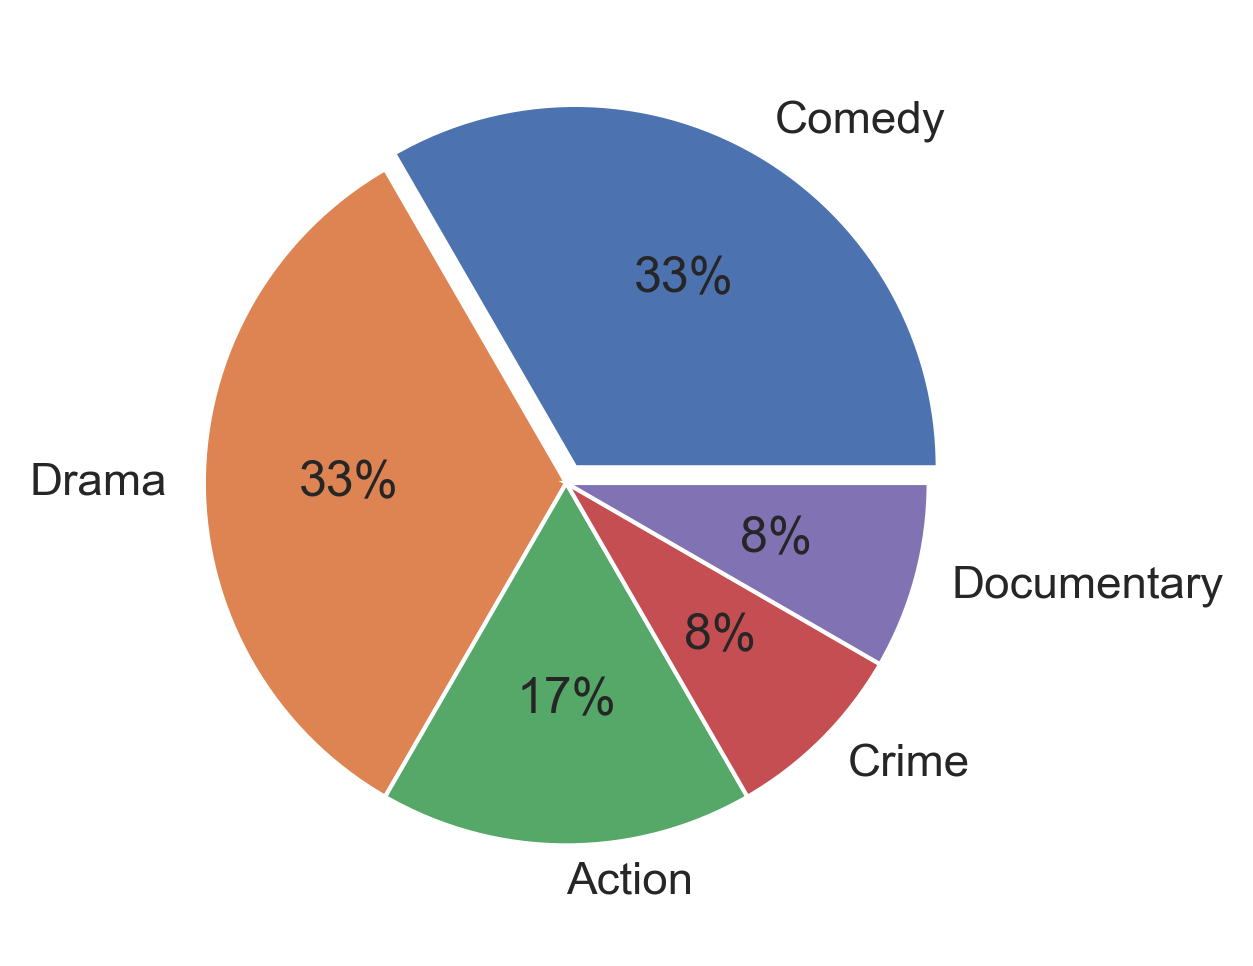

In [17]:
# obtain top 5 genres listed
temp = genre_count(k_neighbours).to_frame(name='count').reset_index().loc[:4]

# plot genre distribution
fig, ax = plt.subplots(figsize=(12,4))

largest_genre = temp.loc[temp['count'].idxmax()]['genres']

plt.pie(data=temp, x='count', labels=temp['genres'], autopct='%.0f%%',
        explode=(temp['genres'] == largest_genre).values * 0.05
       )
plt.show()

Since kNN computes the entire similarity matrix, we have access to all neighbours of an item. We have also increased the size of our genre distribution to 10 i.e., top 10 genres of k neighbours.

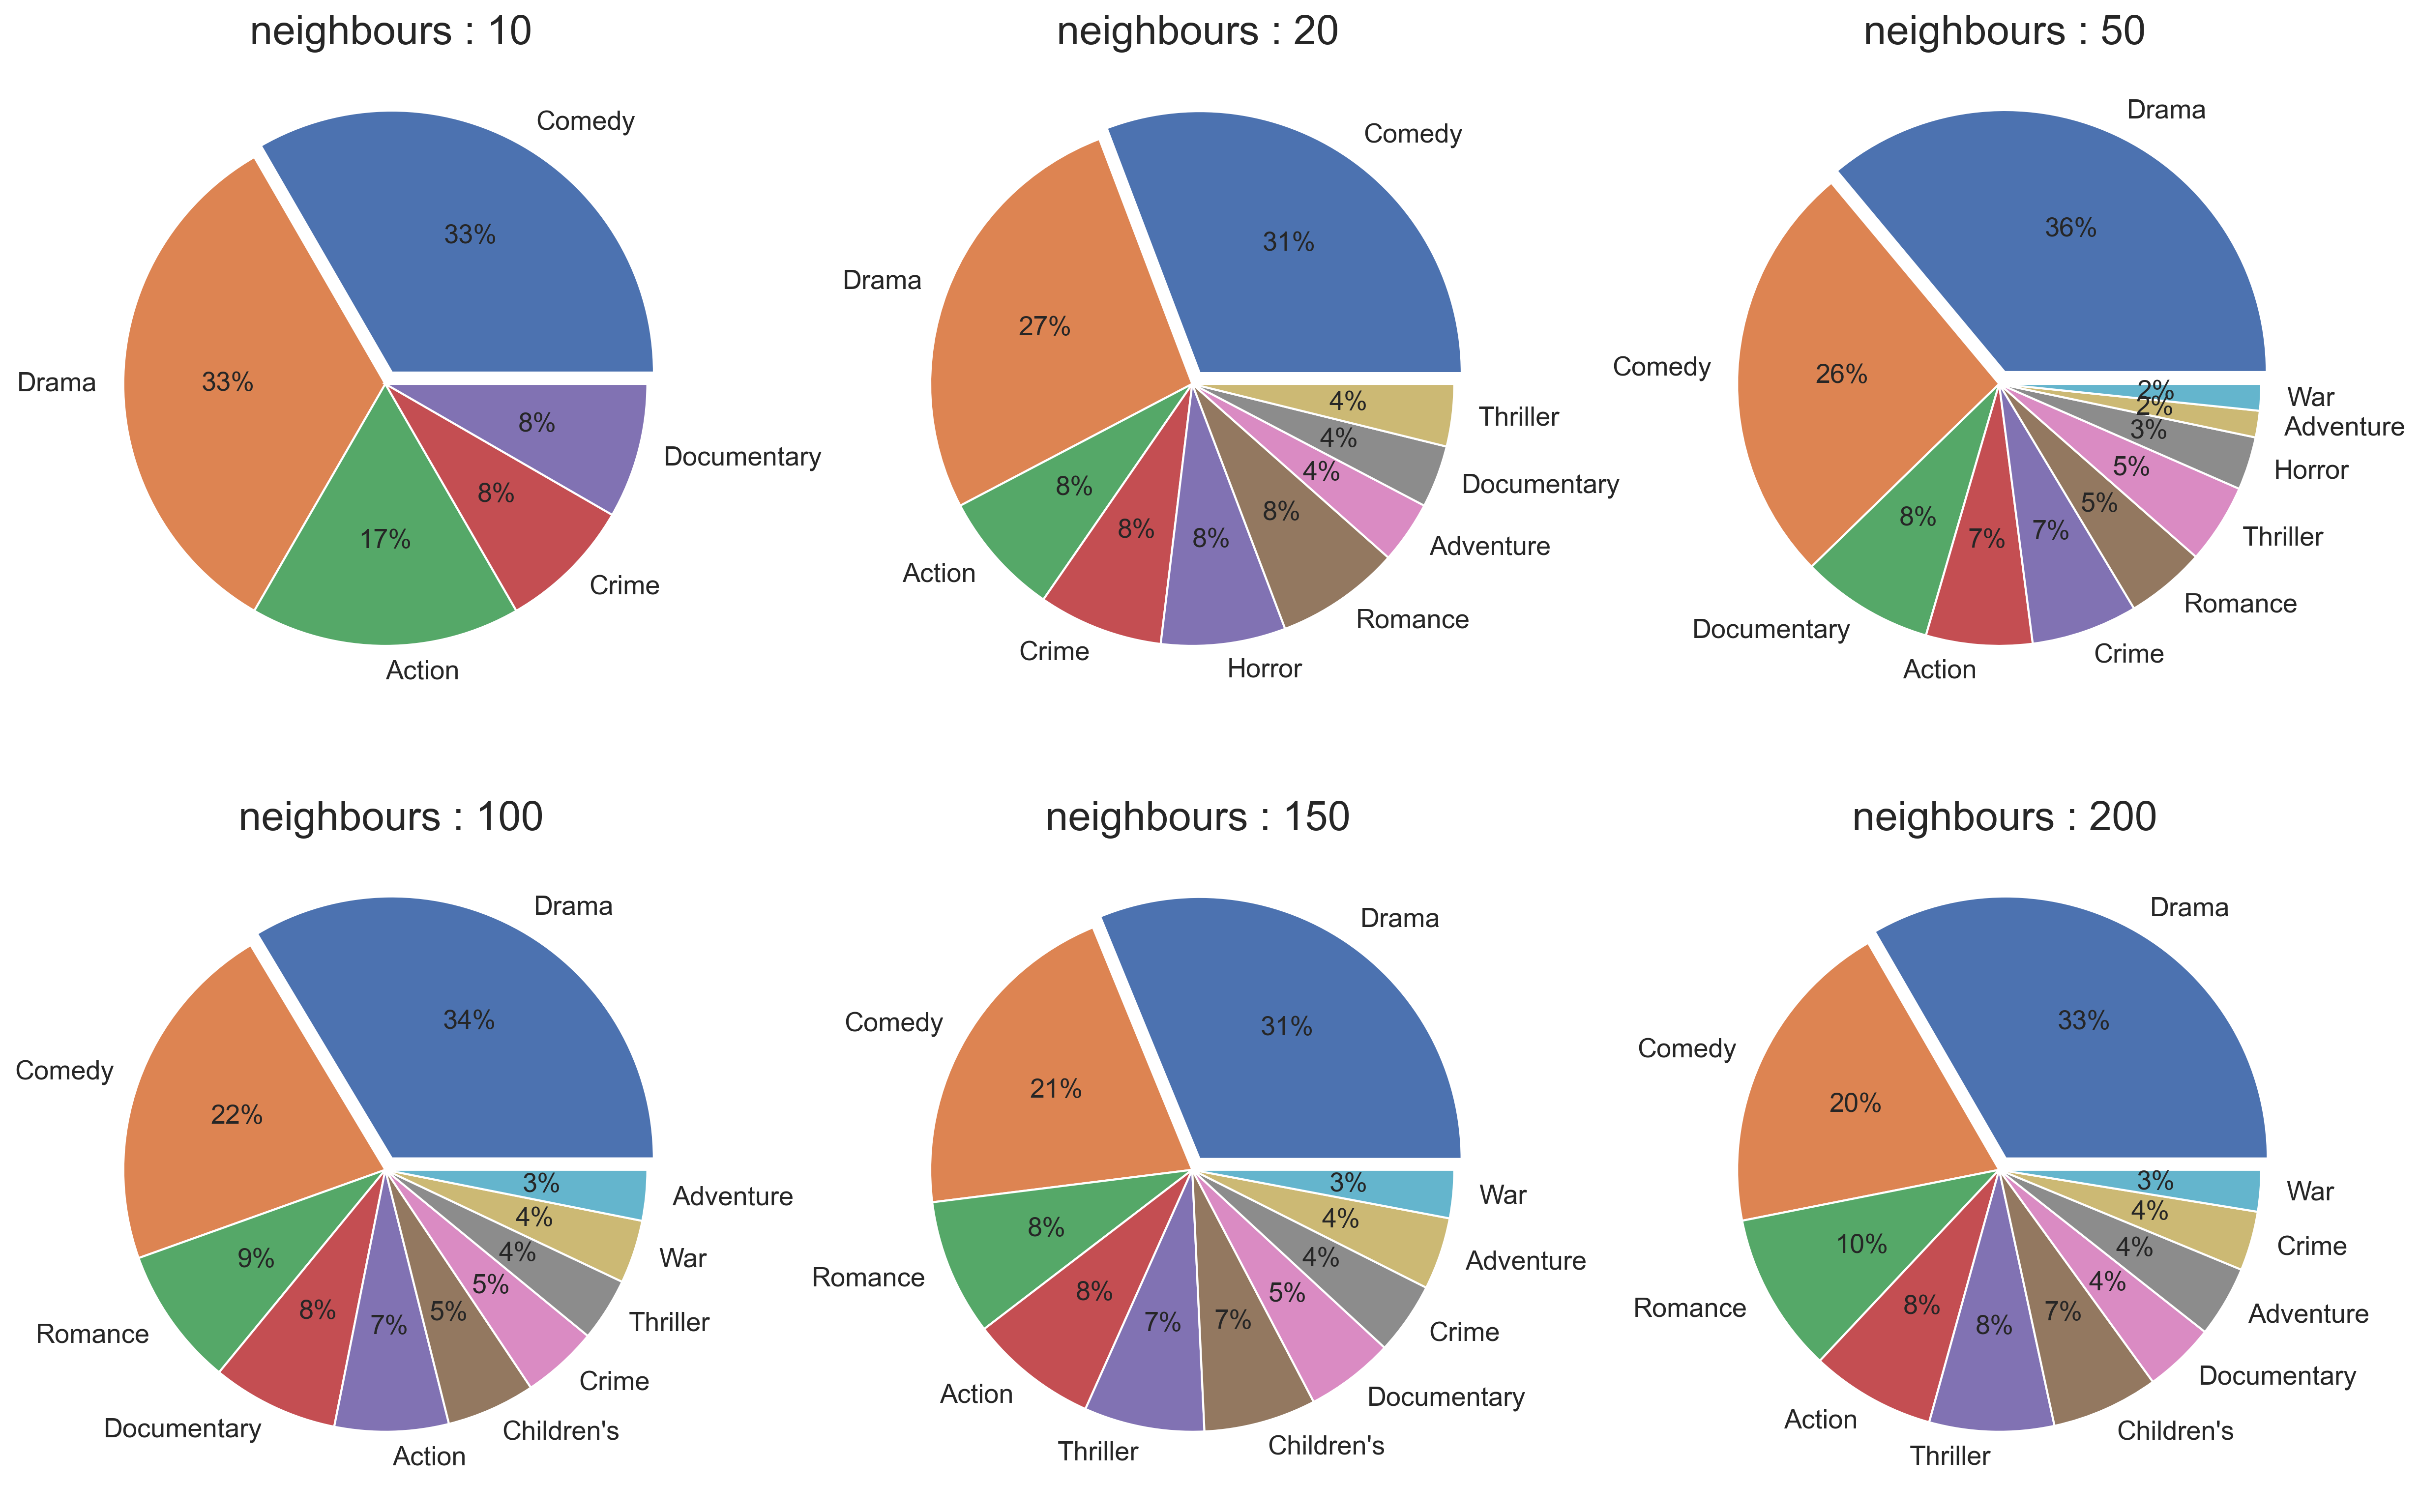

In [18]:
k_val = [10, 20, 50, 100, 150, 200]

fig, ax = plt.subplots(figsize=(20,20))

for n, k in enumerate(k_val):
    # get top 10 genres listed for the movie
    k_neighbours = get_movie_neighbours('Toy Story (1995)', k, algo_item_based)
    temp = genre_count(k_neighbours).to_frame(name='count').reset_index().loc[:9]
    
    # plot genre distribution
    ax = plt.subplot(3, 3, n+1)
    
    largest_genre = temp.loc[temp['count'].idxmax()]['genres']
    
    plt.pie(data=temp, x='count', labels=temp['genres'], autopct='%.0f%%',
            explode=(temp['genres'] == largest_genre).values * 0.05,
            textprops={'fontsize': 13}
           )
    ax.set_title(' neighbours : ' + str(k), fontsize=20)

## Improving the KNN Algorithm (baseline rating)

The KNNwithZScore produces results that seem to degrade as we increase the size of our neighbourhood, however, Surprise also offers an extension of the kNN algorithm known as KNNBaseline which we can use to still use to verify our hypothesis.

In [23]:
from surprise import Dataset, get_dataset_dir, KNNBaseline

# First, train the algorithm to compute the similarities between items
data = Dataset.load_builtin("ml-100k")
trainset = data.build_full_trainset()

sim_options = {"name": "pearson_baseline", "user_based": False}
bsl_options = {"method": "sgd"}
algo = KNNBaseline(sim_options=sim_options, bsl_options=bsl_options)
algo.fit(trainset)

k_neighbours = get_movie_neighbours("Toy Story (1995)", 20, algo) # demo

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [24]:
genres_df.loc[genres_df['name'] == 'Toy Story (1995)']['genres'][1]

"Animation, Children's, Comedy"

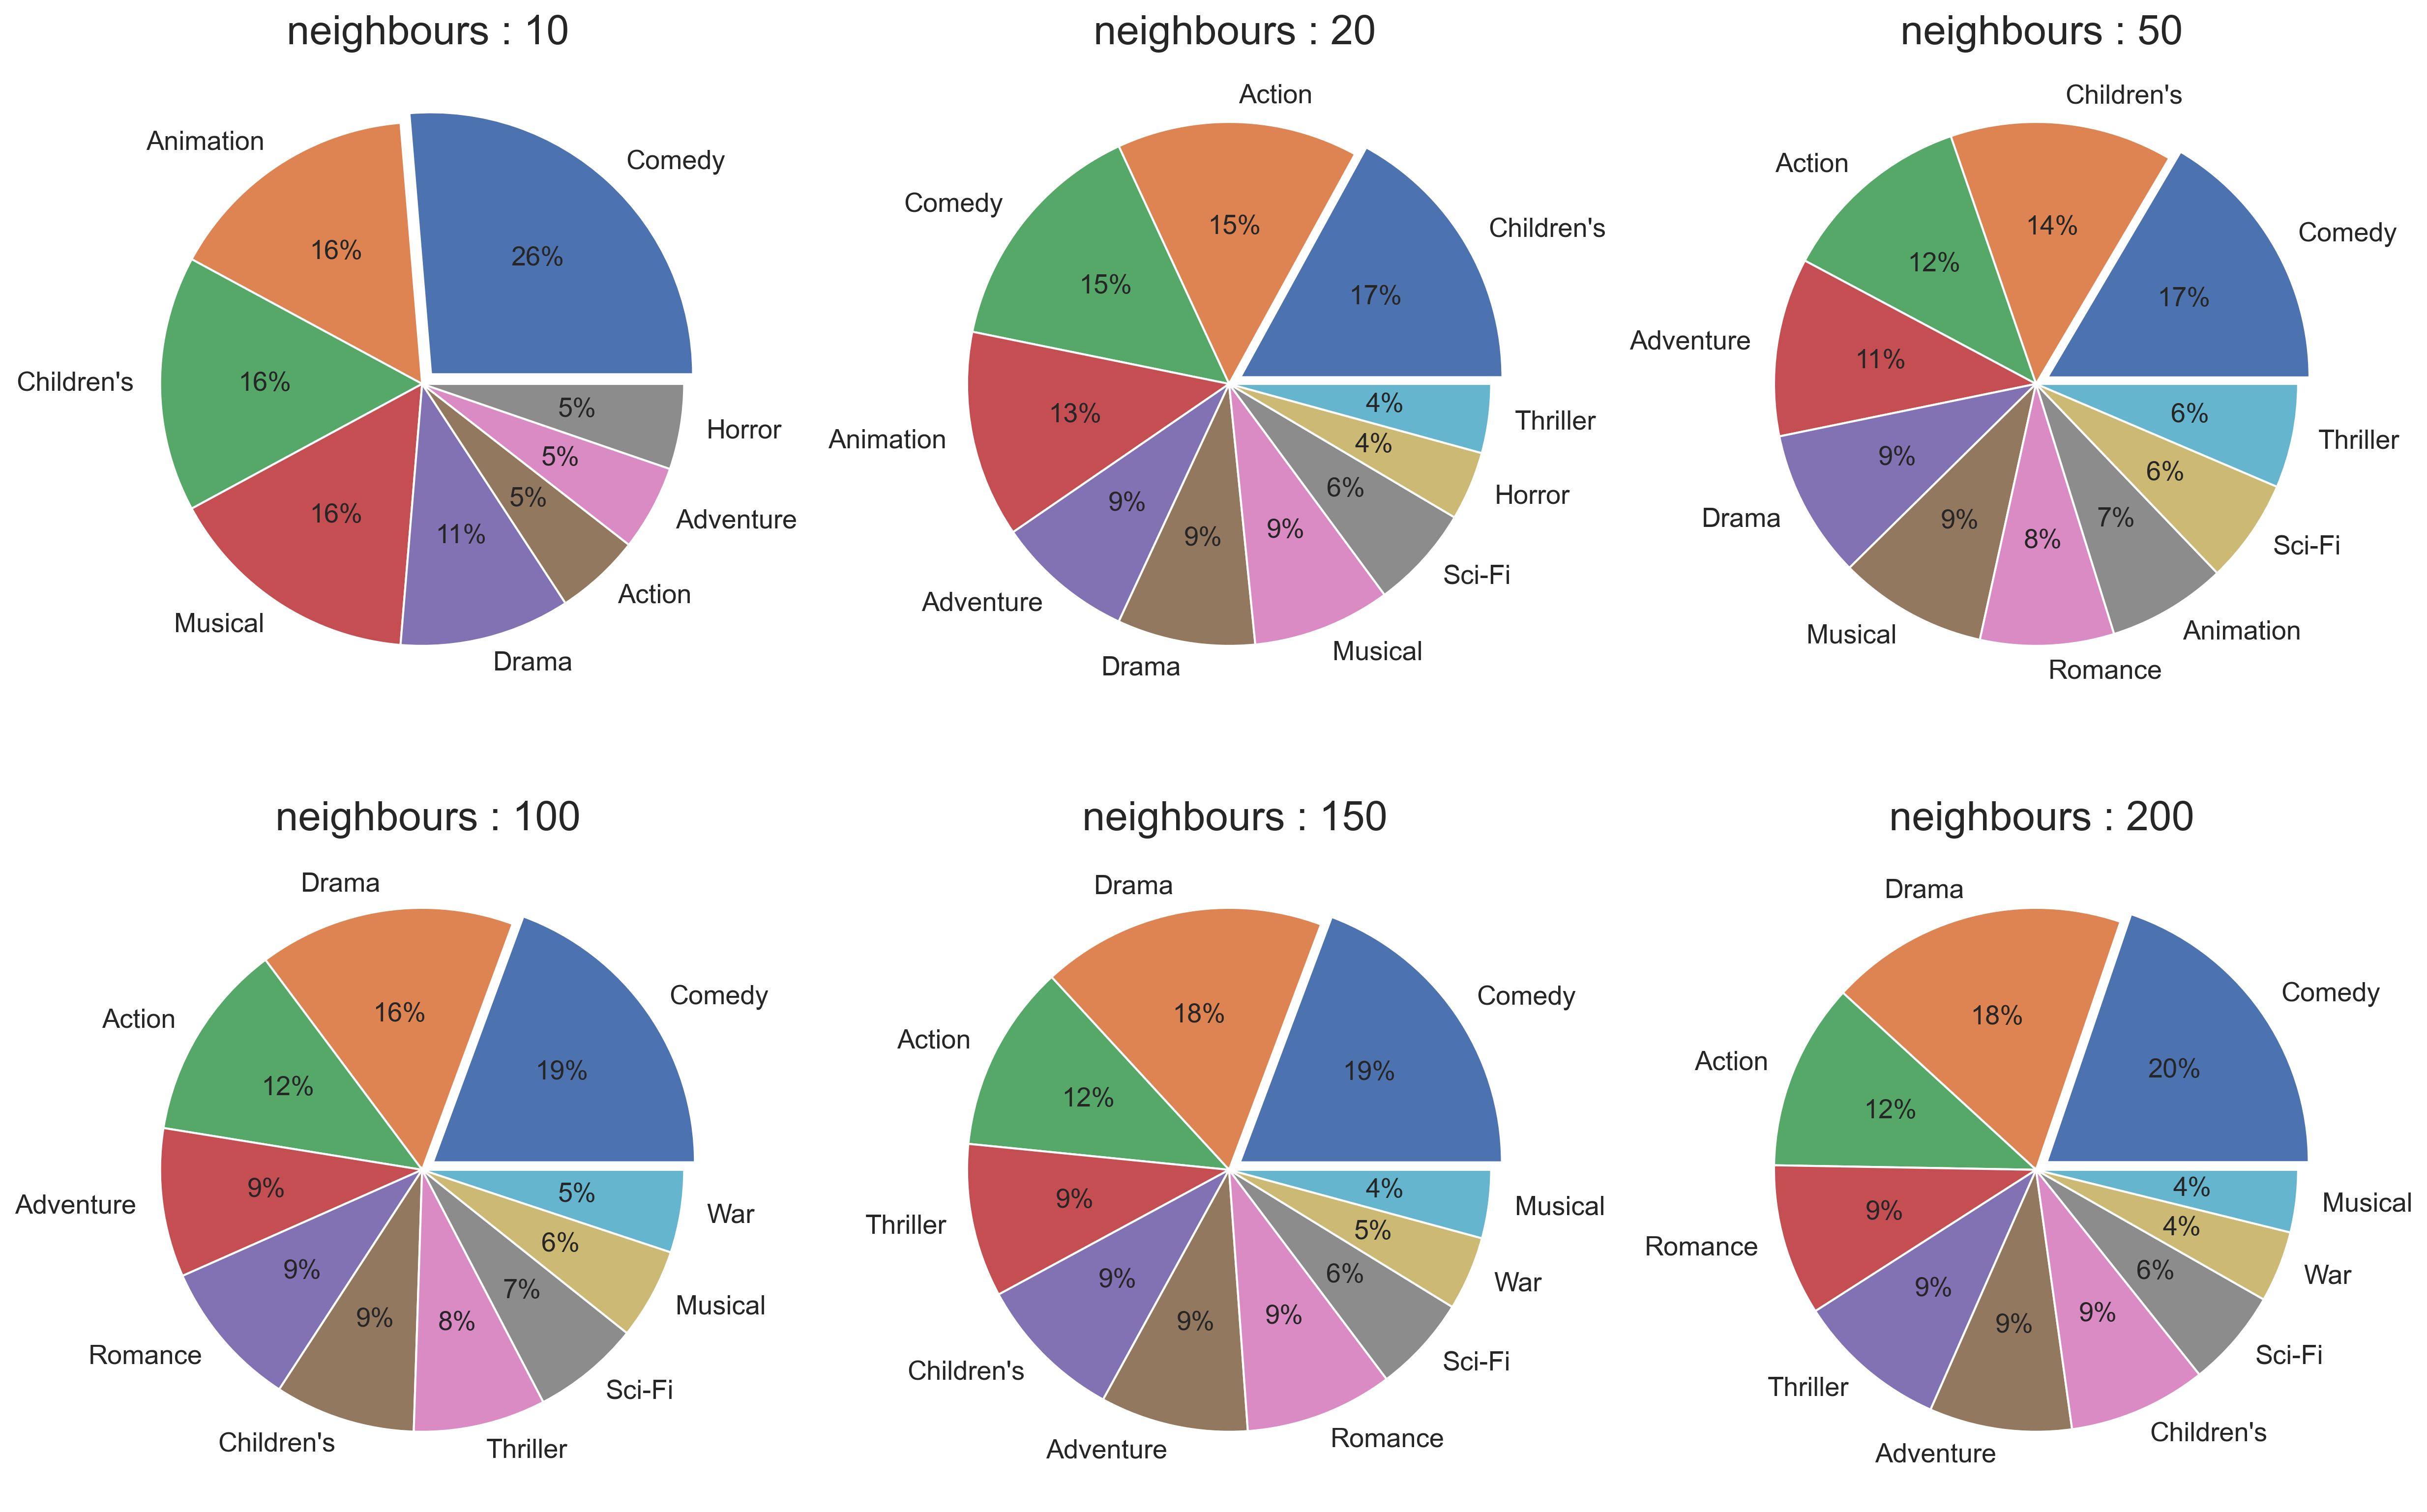

In [25]:
k_val = [10, 20, 50, 100, 150, 200]

fig, ax = plt.subplots(figsize=(20,20))

for n, k in enumerate(k_val):
    # get top 10 genres listed for the movie
    k_neighbours = get_movie_neighbours('Toy Story (1995)', k, algo)
    temp = genre_count(k_neighbours).to_frame(name='count').reset_index().loc[:9]
    
    # plot genre distribution
    ax = plt.subplot(3, 3, n+1)
    
    largest_genre = temp.loc[temp['count'].idxmax()]['genres']
    
    plt.pie(data=temp, x='count', labels=temp['genres'], autopct='%.0f%%',
            explode=(temp['genres'] == largest_genre).values * 0.05,
            textprops={'fontsize': 13}
           )
    ax.set_title(' neighbours : ' + str(k), fontsize=20)